In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import networkx as nx
import math
import random
import networkx as nx
#random.seed(2024)

import shapely

#import maup
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
#maup.progress.enabled = True

from gerrychain import Graph, GeographicPartition, Partition, updaters, Election, MarkovChain
from gerrychain.updaters import Tally, cut_edges
from gerrychain.tree import recursive_seed_part, bipartition_tree
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from gerrychain.constraints.validity import within_percent_of_ideal_population
from functools import partial

from gerrychain.constraints import contiguous

from itertools import combinations
import time

C:\Users\edoua\anaconda3\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\edoua\anaconda3\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
C:\Users\edoua\anaconda3\Lib\site-packages\gerrychain\graph\graph.py:275: UserWarning: GeoDataFrame has no CRS. Did you forget to set it? If you're sure this is correct, you can ignore this warning. Otherwise, please set the CRS using the `crs_override` parameter. Attempting to proceed without a CRS.
  warnings.warn(
C:\Users\edoua\anaconda3\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


<Axes: >

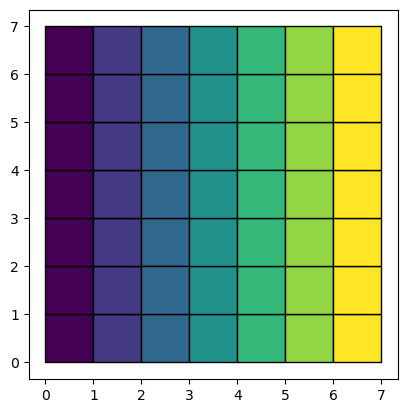

In [5]:
#The pencil metric! This one is good and not evil (probably)
#needs cut_edges to be added to updaters
#The main thing you need to believe is that this is zero iff the partitions are the same
def pencil_dist(partition1,partition2):
    return len(partition1.cut_edges.difference(partition2.cut_edges))+len(partition2.cut_edges.difference(partition1.cut_edges))

#the toymaker makes toy graphs (outputs a gdf)
def toymaker(n,m):
    rootsquare = np.array([(0., 0.), (0., 1.), (1., 1.), (1., 0.), (0., 0.)])
    upshift = np.array([(0., 1.), (0., 1.), (0., 1.), (0., 1.), (0., 1.)])
    rightshift = np.array([(1., 0.), (1., 0.), (1., 0.), (1., 0.), (1., 0.)])
    nodelist = []
    for i in range(m):
        tempsquare = np.array(rootsquare)
        for j in range(n):
            nodelist.append([i*10+j,1,i,j,i,shapely.geometry.Polygon(tempsquare)])
            tempsquare += upshift
        rootsquare+=rightshift
    return gpd.GeoDataFrame(nodelist,columns=["Precinct","TOTPOP","x","y","part","geometry"]) #crs="EPSG:4326" ? idk

#This generates a 6x6 toy
G = Graph.from_geodataframe(toymaker(7,7))

my_updaters = {
    "cut_edges": updaters.cut_edges#,
    #"population": updaters.Tally("TOTPOP", alias="population")
}

starting_partition = Partition(
    G,
    assignment="part",
    updaters=my_updaters
)

#some post-processing to make the initial partition friendlier to swap steps

#for i in range(64):
#    if (i//8)%2 ==0:
#        if i%8 in {0,1,2,3}:
#            starting_partition = starting_partition.flip({i:starting_partition.assignment[i]+1})
#    if (i//8)%2 ==1:
#        if i%8 in {4,5,6,7}:
#            starting_partition = starting_partition.flip({i:starting_partition.assignment[i]-1})

starting_partition.plot(edgecolor="black")

In [7]:
#this sorts the cut_edges of the partition into a dictionary with entries
# {part1,part2} : set(cut_edges between part1 & part2)
#we also truncate all the bins with less than 2 cut_edges, since those can't produce any swap_steps
def sorted_cut_edges(partition):
    bins = dict()
    n=len(partition.parts)
    for i in range(n):
        for j in range(i+1,n):
            bins[frozenset({i,j})] = set()
    for edge in partition.cut_edges:
        bins[frozenset({partition.assignment[edge[0]],partition.assignment[edge[1]]})].add(edge)
    for key, edges in bins.copy().items():
        if len(edges)<2:
            del bins[key]
    return bins

#this will force a swap step between edge1 and edge2
#note this isn't symmetric, it matters how edge1 and edge2 are inputted
#if the edges don't lie on the boundary between the same two parts, this returns the same partition as it was given
def force_swap(partition,edge1,edge2):
    if partition.assignment[edge1[0]] == partition.assignment[edge2[0]]:
        partition = partition.flip({edge1[0]:partition.assignment[edge1[1]],edge2[1]:partition.assignment[edge2[0]]})
    elif partition.assignment[edge1[0]] == partition.assignment[edge2[1]]:
         partition = partition.flip({edge1[0]:partition.assignment[edge1[1]],edge2[0]:partition.assignment[edge2[1]]})
    return partition

#this generates a list of every partition that can be reached in a single swap step
def neighbors(partition):
    neighbors = []
    bins = sorted_cut_edges(partition)
    for edges in bins.values():
        for edge_pair in combinations(edges,2):
            new_partition = force_swap(partition, edge_pair[0], edge_pair[1])
            if contiguous(new_partition):
                neighbors.append(new_partition)
            new_partition = force_swap(partition, edge_pair[1], edge_pair[0])
            if contiguous(new_partition):
                neighbors.append(new_partition)
    #sometimes there are multiple ways of getting to the same neighbor 
    #so we need to remove duplicates from our list
    i = 0
    while i<len(neighbors):
        j=0
        while i+j+1<len(neighbors):
            j+=1
            if pencil_dist(neighbors[i],neighbors[i+j]) == 0:
                del neighbors[i+j]
                j+=-1
        i+=1
    return neighbors

In [3]:
#Toy example
M_7 = 158753814
nodes = []
for i in range(M_7):
    nodes.append((random.random(),random.random()))
print(nodes[0])

(0.9054875911984499, 0.6035011440577244)


In [23]:
past = set()
L_times = []
#pick r so that a euclidean ball of radius r contains 6*10**(-6) of the area in [0,1]x[0,1]
r = (6*10**(-6)/math.pi)**(1/2)
for j in range(20000):
    new_node = random.choice(nodes)
    for old_node in past:
        if (new_node[0]-old_node[0])**2 + (new_node[1]-old_node[1])**2 < r**2:
            L_times.append(len(past)+1)
            past = set()
            break
    past.add(new_node)
print(sum(L_times)/len(L_times))

500.2


In [29]:
def expected_T(N,M):
    factor = float(N/M)
    expectation = 0
    for t in range(math.ceil(M/N)):
        expectation+=factor*(t**2+t)
        factor*=(M-t*N)/M
    return(expectation)

def seek_M(L,N):
    b = 2**int(math.log(L,2)+1)
    overshot = 0
    while not overshot:
        if expected_T(N,b)>L:
            overshot = 1
        else: 
            b*=2
    a = int(b/2)
    while b-a !=1:
        c= (b+a)/2
        if expected_T(N,c)>L:
            b=int(c)
        else:
            a=int(c)
    if expected_T(N,a)-L>L-expected_T(N,b) :
        return b
    else:
        return a

print((seek_M(500.2,6*10**(-6)*M_7)-M_7)/M_7)

-0.046853047574655436


In [7]:
#This cell is probably not needed anymore
partition = starting_partition
current_neighbors = neighbors(partition)
def min_dist(partition, listt):
    return min([pencil_dist(partition, thing) for thing in listt])

In [11]:
t_mix = 300
n_sample=50*500
n_steps = t_mix*n_sample

partition=starting_partition
neighbor_list = neighbors(partition)
past=set()
L_times=[362, 638, 878, 1131, 550, 345, 227, 884, 457, 627, 199, 439, 614, 1237, 456, 1032, 268, 103, 1011, 460, 998]
#L_times=[261, 35, 349, 224, 215, 347, 59, 356, 17, 266, 39, 209, 355, 358, 105, 415, 62]
#L_times =[213, 273, 50, 440, 290, 423, 288, 134, 365, 288, 334, 342, 207, 278, 230, 355, 234, 272, 310, 492, 344, 29, 270, 344, 325, 383]

In [ ]:
r=13
for i_step in range(1,n_steps+1):
    #here = 1
    #while here:
    new_partition = random.choice(neighbor_list)
    new_neighbors = neighbors(new_partition)
    if random.random()<min(1,len(neighbor_list)/len(new_neighbors)):
        #here =0
        neighbor_list = list(new_neighbors)
        partition = new_partition
    if i_step%t_mix ==0:
        for old_partition in past:
            if pencil_dist(old_partition, partition)<r:
                L_times.append(len(past)+1)
                past=set()
                #hitting_times.append(len(past)+2)
                break
        past.add(partition)
        print(f"Finished step {int(i_step/t_mix)} out of {n_sample}. Hitting times: {L_times}.",end="\r")

In [33]:
sum(N_values)/len(N_values)

599.5178571428571